In [3]:
from PIL import Image
import os
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Activation, BatchNormalization, concatenate, AveragePooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.models import load_model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [5]:
#이미지 dir 경로 풀러오기 (코드와 이미지 폴더가 같은 폴더 안에 있어야 됨)
image_dir_path = os.path.dirname(os.path.abspath("__file__")) + '/image'
categories = os.listdir('./image')
select_cat = []
nb_classes = 0
mnist = tf.keras.datasets.mnist
image_w = 224
image_h = 224

x = []
y = []
#이미지 몇개 이상 분포만 불러오는 부분
count = 0;
target_names = []
for idx, c in enumerate(categories):
    dir = image_dir_path + '/' + c
    f = glob(dir+'/*.jpg')
    
   # if len(f) >= 100:
    nb_classes += 1
    select_cat.append(dir)
    target_names.append(c)
print(select_cat) #입력된 클래스 폴더 경로 

['C:\\Users\\HYEONGCHEOL\\Desktop\\TestFile/image/Ae_salang', 'C:\\Users\\HYEONGCHEOL\\Desktop\\TestFile/image/Ae_seulpeul', 'C:\\Users\\HYEONGCHEOL\\Desktop\\TestFile/image/Ag_aghal', 'C:\\Users\\HYEONGCHEOL\\Desktop\\TestFile/image/An_pyeonan', 'C:\\Users\\HYEONGCHEOL\\Desktop\\TestFile/image/A_ai', 'C:\\Users\\HYEONGCHEOL\\Desktop\\TestFile/image/A_uisimhal', 'C:\\Users\\HYEONGCHEOL\\Desktop\\TestFile/image/Baek_huin', 'C:\\Users\\HYEONGCHEOL\\Desktop\\TestFile/image/Bal_pil', 'C:\\Users\\HYEONGCHEOL\\Desktop\\TestFile/image/Bang_hemel', 'C:\\Users\\HYEONGCHEOL\\Desktop\\TestFile/image/Bang_mageul', 'C:\\Users\\HYEONGCHEOL\\Desktop\\TestFile/image/Bang_mo', 'C:\\Users\\HYEONGCHEOL\\Desktop\\TestFile/image/Bang_nara', 'C:\\Users\\HYEONGCHEOL\\Desktop\\TestFile/image/Bang_noeul', 'C:\\Users\\HYEONGCHEOL\\Desktop\\TestFile/image/Ban_dorikil', 'C:\\Users\\HYEONGCHEOL\\Desktop\\TestFile/image/Ban_duduk', 'C:\\Users\\HYEONGCHEOL\\Desktop\\TestFile/image/Ban_gaji', 'C:\\Users\\HYEONGCHEOL\

In [3]:
#이미지 데이터 불러오고 라벨링
for index, cat in enumerate(select_cat):
    files = glob(select_cat[index]+'/*.jpg')
    for i, f in enumerate(files):
            img = Image.open(f)
            img = img.convert("RGB")
            img = img.resize((image_w, image_h))
            data = np.asarray(img)
            
            x.append(data)
            y.append(index)

In [4]:
#이미지 행렬화 및 확인
x = np.array(x)
y = np.array(y)
print(x.shape)
print(y.shape)

(18438, 224, 224, 3)
(18438,)


In [7]:
#트레인 테스트 데이터 스플릿(8:2)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)
xy = (x_train, x_test, y_train, y_test)
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(14750, 224, 224, 3) (14750,)
(3688, 224, 224, 3) (3688,)


In [6]:
#DenseNet Setting
growth_rate = 16
theta = 0.5

def DenseBlock(x, num): #DenseBlock정의(relu 사용)
    layer_list = [x]
    for i in range(num):
        x1 = BatchNormalization()(x)
        x1 = Activation('relu')(x1)
        x1 = Conv2D(growth_rate*4, kernel_size=1, padding='same', use_bias=False)(x1)
        x1 = BatchNormalization()(x1)
        x1 = Activation('relu')(x1)
        x1 = Conv2D(growth_rate, kernel_size=3, padding='same', use_bias=False)(x1)
        layer_list.append(x1)
        x = concatenate(layer_list, axis=-1) 
    return x


def Transition_layer(x, name):
    num_ch = int(x.get_shape().as_list()[-1] * theta) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_ch, kernel_size=3, padding='same', use_bias=False)(x)
    x = AveragePooling2D(pool_size=2, strides=2, padding='same', name=name)(x)
    
    return x

#DenseNet Layer 설정
inputs = Input(shape=(224, 224, 3))
x = Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs) # (112, 112)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x) # (56, 56)

x = DenseBlock(x, 3) # (56, 56)
x = Transition_layer(x, 'transition_layer_1') # (28, 28)
x = DenseBlock(x, 6) # (28, 28)
x = Transition_layer(x, 'transition_layer_2') # (14, 14)
x = DenseBlock(x, 12) # (14, 14)
x = Transition_layer(x, 'transition_layer_3') # (7, 7)
x = DenseBlock(x, 8) # (7, 7)
x = GlobalAveragePooling2D()(x) # (None, 262)
outputs = Dense(nb_classes, activation='softmax')(x) # (None, 527)

In [7]:
model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 112, 112, 64) 9408        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_62 (BatchNo (None, 112, 112, 64) 256         conv2d_62[0][0]                  
__________________________________________________________________________________________________
activation_62 (Activation)      (None, 112, 112, 64) 0           batch_normalization_62[0][0]     
______________________________________________________________________________________________

In [12]:
y_train_one_hot = to_categorical(y_train, nb_classes)
y_test_one_hot = to_categorical(y_test, nb_classes)

In [17]:
#모델 학습(Adam)
model.compile('Adam', loss='categorical_crossentropy', metrics=['acc'])
history_Adam = model.fit(x_train, y_train_one_hot, batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
369/369 [==============================] - 1722s 5s/step - loss: 4.4499 - acc: 0.0602 - val_loss: 748.0615 - val_acc: 0.0031
Epoch 2/20
369/369 [==============================] - 1717s 5s/step - loss: 2.7247 - acc: 0.2808 - val_loss: 343.7235 - val_acc: 0.0047
Epoch 3/20
369/369 [==============================] - 1714s 5s/step - loss: 1.8205 - acc: 0.4939 - val_loss: 569.5763 - val_acc: 0.0081
Epoch 4/20
369/369 [==============================] - 1722s 5s/step - loss: 1.2556 - acc: 0.6422 - val_loss: 204.9877 - val_acc: 0.0085
Epoch 5/20
369/369 [==============================] - 1710s 5s/step - loss: 0.9116 - acc: 0.7422 - val_loss: 182.3103 - val_acc: 0.0081
Epoch 6/20
369/369 [==============================] - 1727s 5s/step - loss: 0.7507 - acc: 0.7766 - val_loss: 147.7158 - val_acc: 0.0064
Epoch 7/20
369/369 [==============================] - 1721s 5s/step - loss: 0.6013 - acc: 0.8244 - val_loss: 373.2368 - val_acc: 0.0085
Epoch 8/20
369/369 [============================

In [18]:
#모델 학습2(SGD)
model.compile('SGD', loss='categorical_crossentropy', metrics=['acc'])
history_SGD = model.fit(x_train, y_train_one_hot, batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
369/369 [==============================] - 1728s 5s/step - loss: 0.0833 - acc: 0.9699 - val_loss: 0.4175 - val_acc: 0.9064
Epoch 2/20
369/369 [==============================] - 1708s 5s/step - loss: 0.0338 - acc: 0.9902 - val_loss: 0.3989 - val_acc: 0.9102
Epoch 3/20
369/369 [==============================] - 1708s 5s/step - loss: 0.0354 - acc: 0.9905 - val_loss: 0.7673 - val_acc: 0.8325
Epoch 4/20
369/369 [==============================] - 1708s 5s/step - loss: 0.0220 - acc: 0.9961 - val_loss: 0.5657 - val_acc: 0.8783
Epoch 5/20
369/369 [==============================] - 1720s 5s/step - loss: 0.0228 - acc: 0.9948 - val_loss: 0.3781 - val_acc: 0.9153
Epoch 6/20
369/369 [==============================] - 1730s 5s/step - loss: 0.0211 - acc: 0.9965 - val_loss: 0.4004 - val_acc: 0.9095
Epoch 7/20
369/369 [==============================] - 1719s 5s/step - loss: 0.0201 - acc: 0.9961 - val_loss: 0.3729 - val_acc: 0.9156
Epoch 8/20
369/369 [==============================] - 1715s 5s

In [25]:
#모델 추가적 학습이 필요한 경우
model.compile('SGD', loss='categorical_crossentropy', metrics=['acc'])
history_SGD2 = model.fit(x_train, y_train_one_hot, batch_size=32, epochs=5, validation_split=0.2)

Epoch 1/5
369/369 [==============================] - 1735s 5s/step - loss: 0.0111 - acc: 0.9992 - val_loss: 0.3653 - val_acc: 0.9173
Epoch 2/5
369/369 [==============================] - 1709s 5s/step - loss: 0.0110 - acc: 0.9993 - val_loss: 0.3669 - val_acc: 0.9176
Epoch 3/5
369/369 [==============================] - 1718s 5s/step - loss: 0.0110 - acc: 0.9989 - val_loss: 0.3659 - val_acc: 0.9183
Epoch 4/5
369/369 [==============================] - 1716s 5s/step - loss: 0.0101 - acc: 0.9991 - val_loss: 0.3877 - val_acc: 0.9156
Epoch 5/5
369/369 [==============================] - 1721s 5s/step - loss: 0.0110 - acc: 0.9993 - val_loss: 0.3663 - val_acc: 0.9193


In [26]:
#Test data 확인
test_loss, test_acc = model.evaluate(x_train,  y_train_one_hot, verbose=2)
print('\n테스트 loss:', test_loss)
print('\n테스트 acc', test_acc)

461/461 - 257s - loss: 0.0760 - acc: 0.9838

테스트 loss: 0.07597751170396805

테스트 acc 0.9837965965270996


In [27]:
#모델 저장
model.save('densenet_Comparison_of_cursive_script_100.h5')

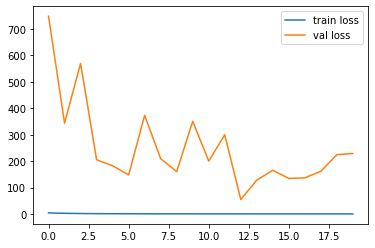

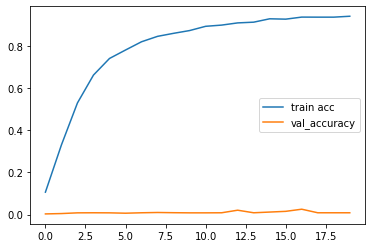

In [28]:
#Adam 학습 중 loss, acc 그래프
plt.plot(history_Adam.history['loss'],label='train loss')
plt.plot(history_Adam.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(history_Adam.history['acc'], label='train acc')
plt.plot(history_Adam.history['val_acc'], label='val_accuracy')
plt.legend()
plt.show()

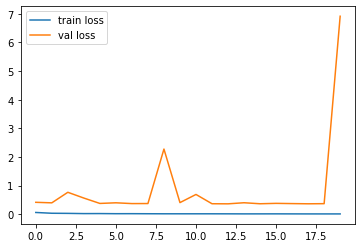

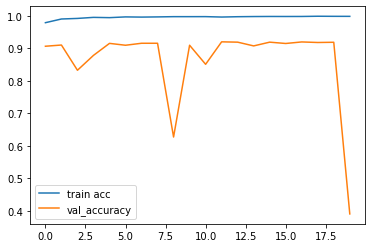

In [29]:
#SGD 학습 중 loss, acc 그래프
plt.plot(history_SGD.history['loss'],label='train loss')
plt.plot(history_SGD.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(history_SGD.history['acc'], label='train acc')
plt.plot(history_SGD.history['val_acc'], label='val_accuracy')
plt.legend()
plt.show()

In [46]:
#분류 결과 저장 및 one_hot_decoding
y_pred_one_hot = model.predict(x_train)
y_pred = np.argmax(y_pred_one_hot, axis=1).reshape(-1)

In [47]:
#모델의  precision    recall  f1-score   값 확인(클래스별 및 평균)
rgeprint(classification_report(y_train, y_pred, target_names=tat_names))

                 precision    recall  f1-score   support

       Ag_aghal       0.97      0.98      0.97        94
     An_pyeonan       1.00      1.00      1.00        97
      Baek_huin       1.00      0.99      0.99        80
        Bi_anil       0.99      1.00      0.99        86
   Bong_batdeul       0.98      1.00      0.99        86
      Bun_nanul       0.99      1.00      0.99        80
        Bu_anil       0.99      1.00      0.99       262
     Cha_daleul       0.94      0.96      0.95       102
       Cheo_gos       0.98      0.98      0.98       107
        Che_mom       1.00      0.99      0.99        97
  Chig_beobchig       0.97      1.00      0.98        94
   Chin_chinhal       1.00      0.96      0.98        96
    Choe_gajang       0.96      0.95      0.95       100
        Cho_pul       0.95      0.95      0.95       107
       Chun_bom       0.98      0.99      0.98        83
     Chwi_gajil       0.95      0.97      0.96       174
   Dang_mattang       1.00    